#### Setup

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
from sentinelhub import SHConfig
config = SHConfig()

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

#### Loading the Data

In [2]:
# One-off dataset creation

with open("Datasets/site_locations.csv") as file:
        locations = pd.read_csv(file,sep=",")

with open("Datasets/bestand_04_11_22.csv") as file:
        bestand = pd.read_csv(file,sep=",")

# # create a column where we map the site abbreviation to the respective bounding box
# locations = locations.dropna()
# bestand["LocationBBox"] = bestand["SITE"]
# bestand["BoundingBox"] = bestand["LocationBBox"].map(dict(zip(locations["Abbreviation"],locations["BoundingBox"])))

# # Calculate the bboxes
resolution = 60
# bbox_object_list = []
# bbox_size_list = []
# for bbox_coords in bestand["BoundingBox"]:
#     bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)
#     bbox_size = bbox_to_dimensions(bbox, resolution=resolution)

#     bbox_object_list.append([bbox])
#     bbox_size_list.append(bbox_size)

# bestand["BoundingBoxSize"] = bbox_size_list

# # update the file
# bestand.to_csv("Datasets/bestand_04_11_22.csv")

#### Script Preparation

In [3]:
from typing import Any, Optional, Tuple

def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: Optional[Tuple[float, float]] = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [4]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

#### Downloading a series of images from the same field

In [5]:
import itertools

# downloading timeseries
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 12, 31)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

# modify to accept timeslot, bbox, size and path
def request_all_bands_timed(time_interval,bbox,bbox_size,location_name):
    return SentinelHubRequest(
        data_folder="SatelliteImages/SatelliteImages"+location_name,
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=bbox_size,
        config=config,
    )
# allow the DF to save the response objects
bestand["AllBandsTimed"] = np.nan
bestand["AllBandsTimed"] = bestand["AllBandsTimed"].astype('object')

for row in bestand.itertuples():
    print("Starting row ",row.LocationBBox)
    # create a list of requests
    bbox = BBox(bbox=row.BoundingBox, crs=CRS.WGS84)
    bbox_size = bbox_to_dimensions(bbox, resolution=resolution)
    list_of_requests = [request_all_bands_timed(slot, bbox, bbox_size, row.LocationBBox).get_data(save_data=True) for slot in slots]
    bestand.at[row.Index,"AllBandsTimed"] = list_of_requests

Monthly time windows:

('2019-01-01', '2019-01-29')
('2019-01-29', '2019-02-26')
('2019-02-26', '2019-03-26')
('2019-03-26', '2019-04-23')
('2019-04-23', '2019-05-21')
('2019-05-21', '2019-06-18')
('2019-06-18', '2019-07-16')
('2019-07-16', '2019-08-13')
('2019-08-13', '2019-09-10')
('2019-09-10', '2019-10-08')
('2019-10-08', '2019-11-05')
('2019-11-05', '2019-12-03')
Starting row  Abs
Starting row  Abs
Starting row  Abs
Starting row  Au1
Starting row  Au1
Starting row  Au1
Starting row  Au2
Starting row  Au2
Starting row  Au2
Starting row  Burg1
Starting row  Burg1
Starting row  Burg1
Starting row  Burg2
Starting row  Burg2
Starting row  Burg2
Starting row  Eis
Starting row  Eis
Starting row  Eis
Starting row  Fischa
Starting row  Fischa
Starting row  Fischa
Starting row  Grü
Starting row  Grü
Starting row  Grü
Starting row  Lack1
Starting row  Lack1
Starting row  Lack1
Starting row  Lack2
Starting row  Lack2
Starting row  Lack2
Starting row  Man1
Starting row  Man1
Starting row  Man1

#### Plotting the Band Histograms

In [6]:
ex_1 = bestand.at[2,"AllBandsTimed"]

# move the bands to a nice np-array
stacked_bands = np.stack(ex_1[0])
stacked_bands = np.moveaxis(stacked_bands, 3, 0).squeeze()
stacked_bands.shape

(13, 3, 4)

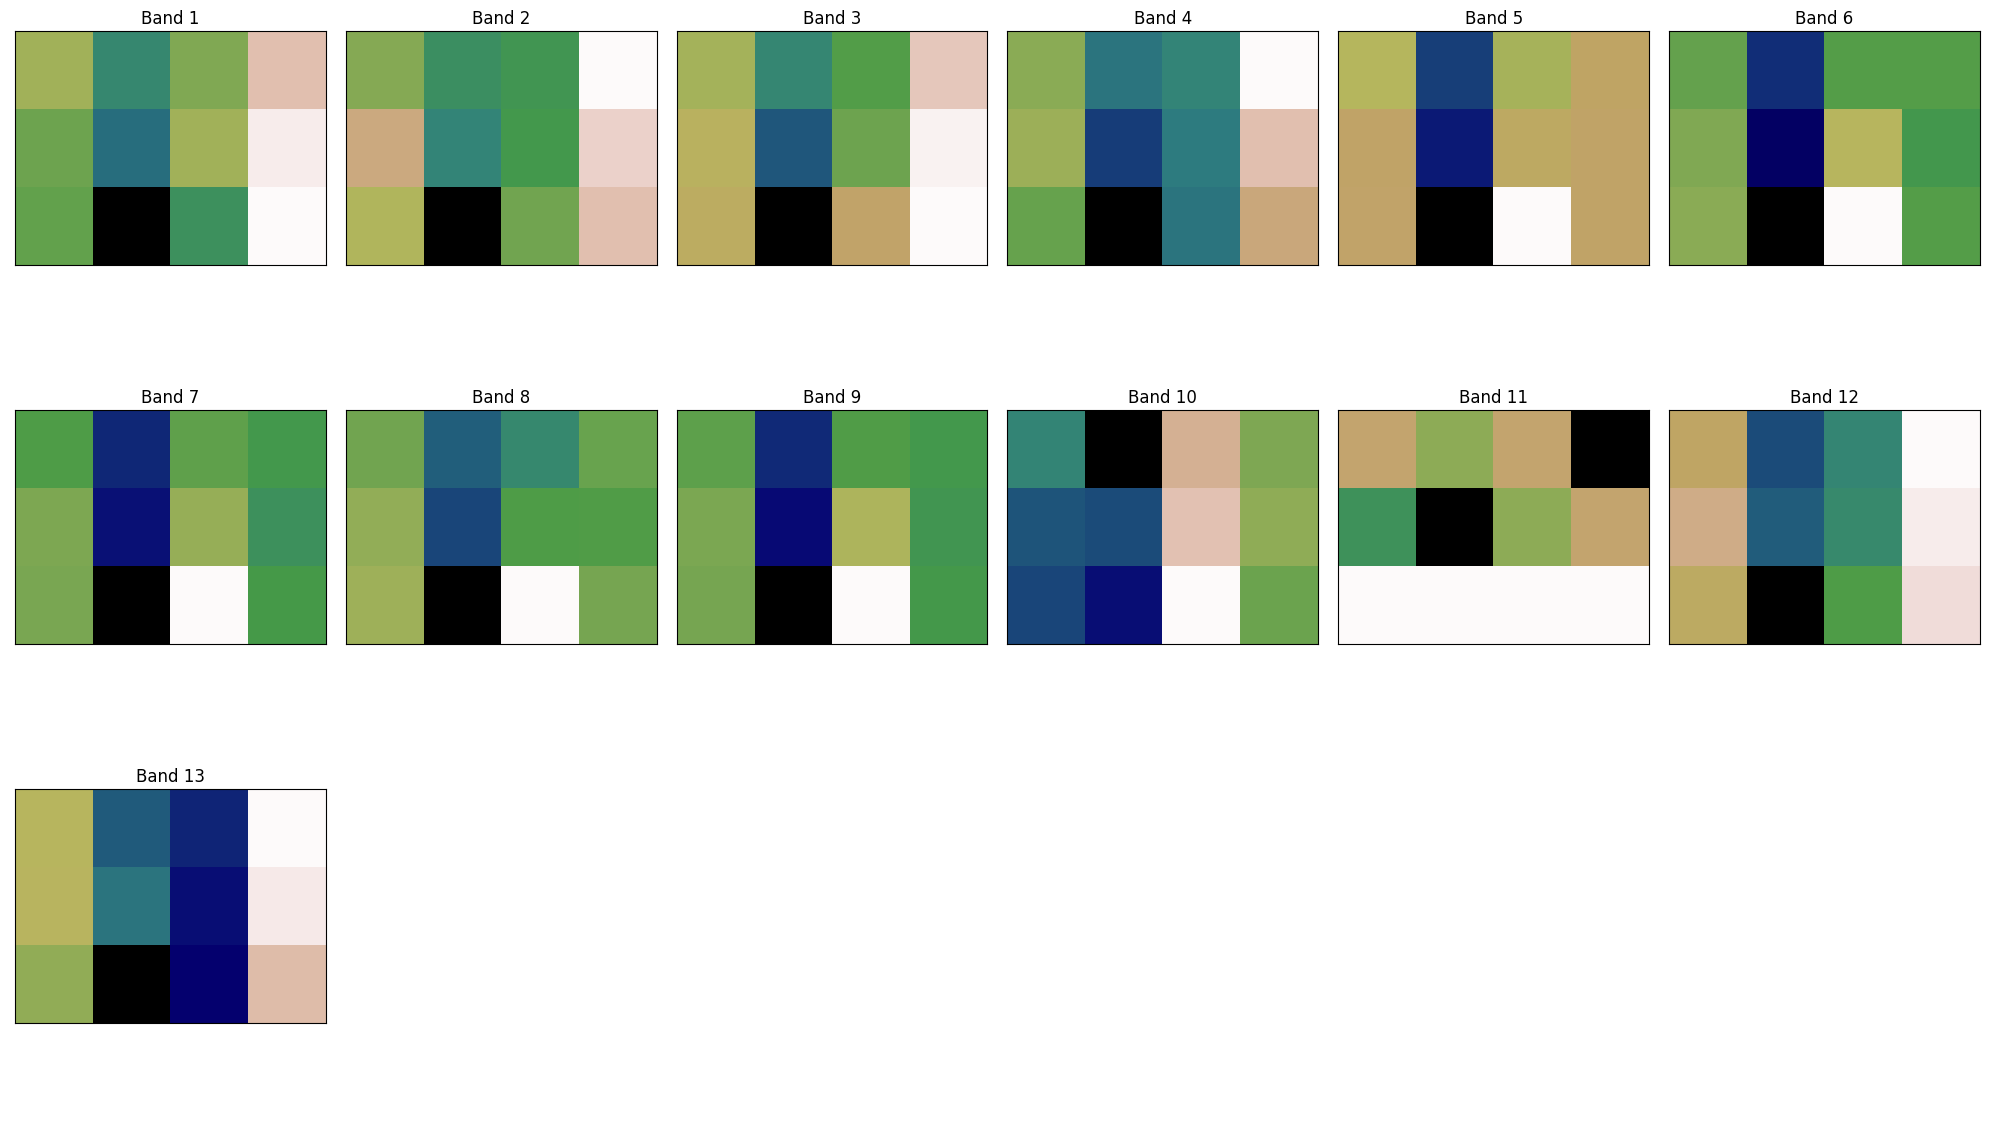

In [7]:
# Plot all bands
ep.plot_bands(stacked_bands, 
              cmap = 'gist_earth', 
              figsize = (20, 12), 
              cols = 6, 
              cbar = False)
plt.show()

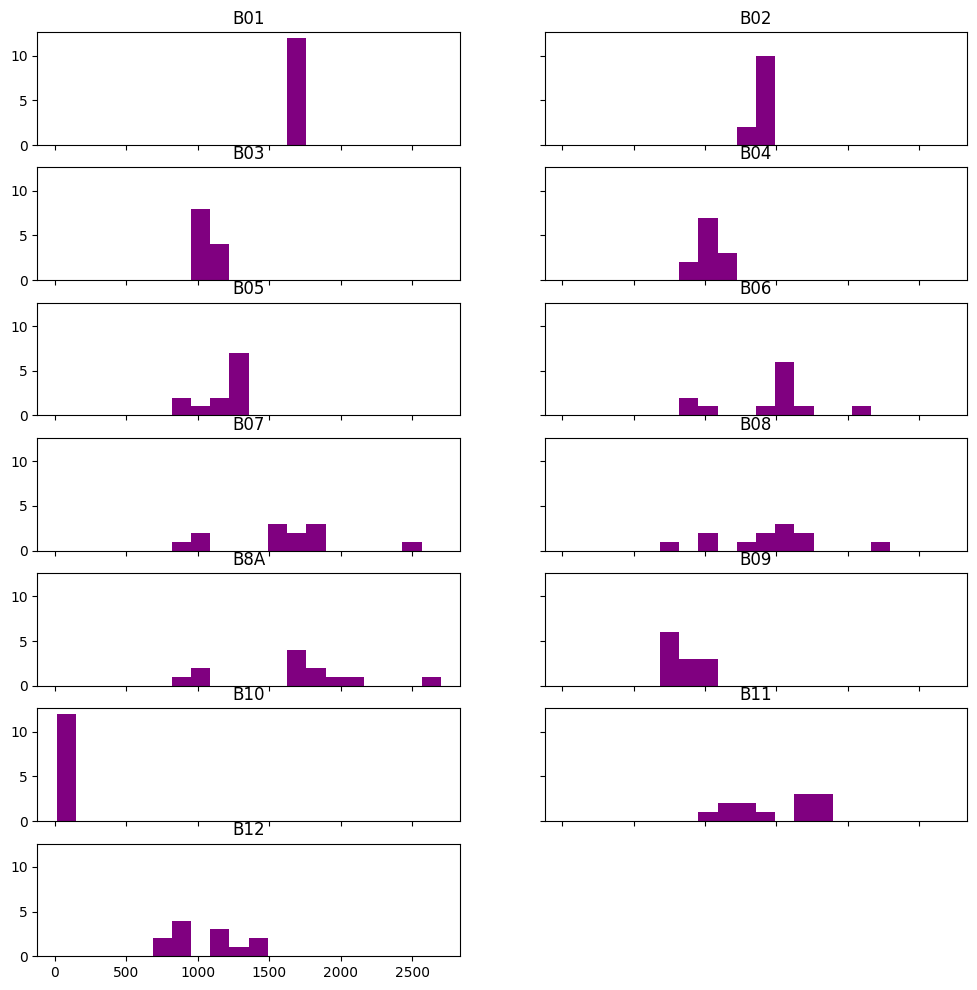

In [8]:
# Create the list of titles for each band. The titles and colors listed
# in this example reflect the order and wavelengths of the Landsat 8 bands
titles = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]

# and a histogram of the spectrums
ep.hist(stacked_bands, title=titles)
plt.show()

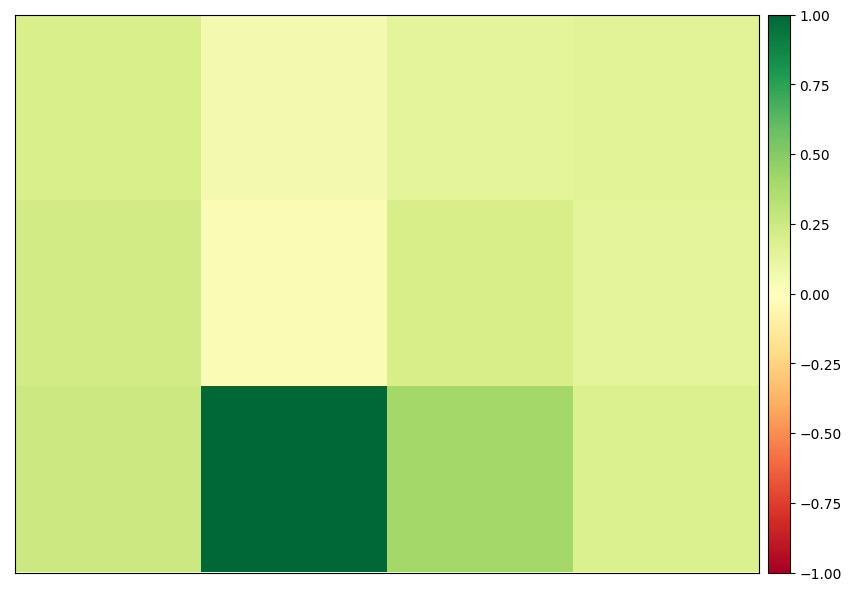

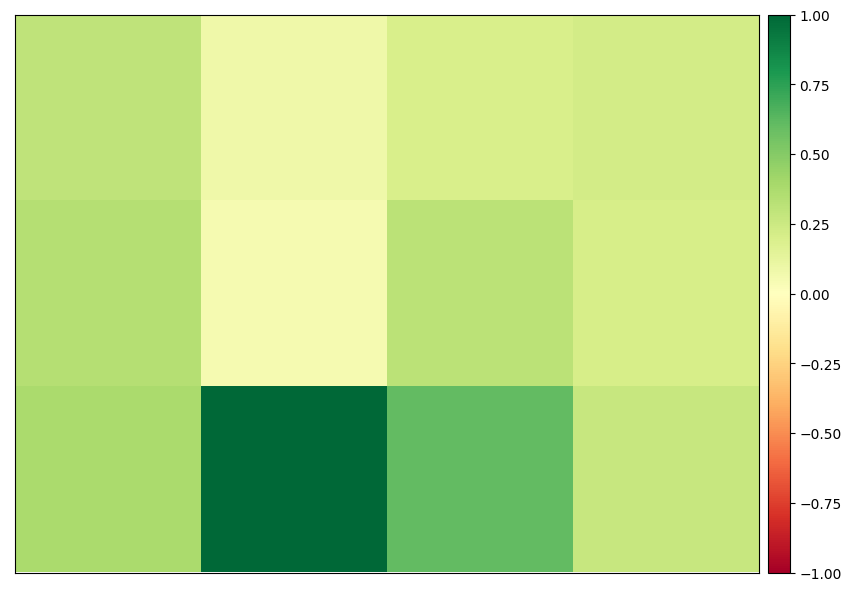

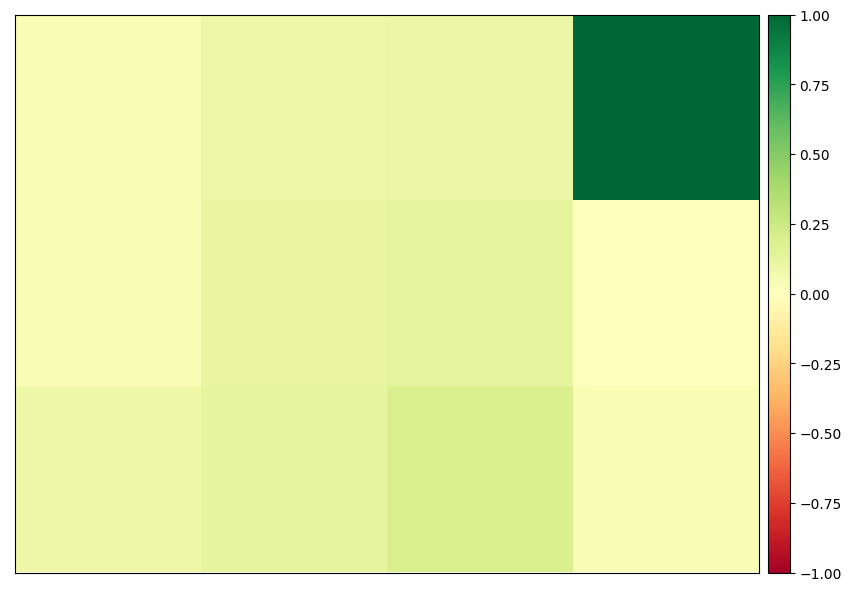

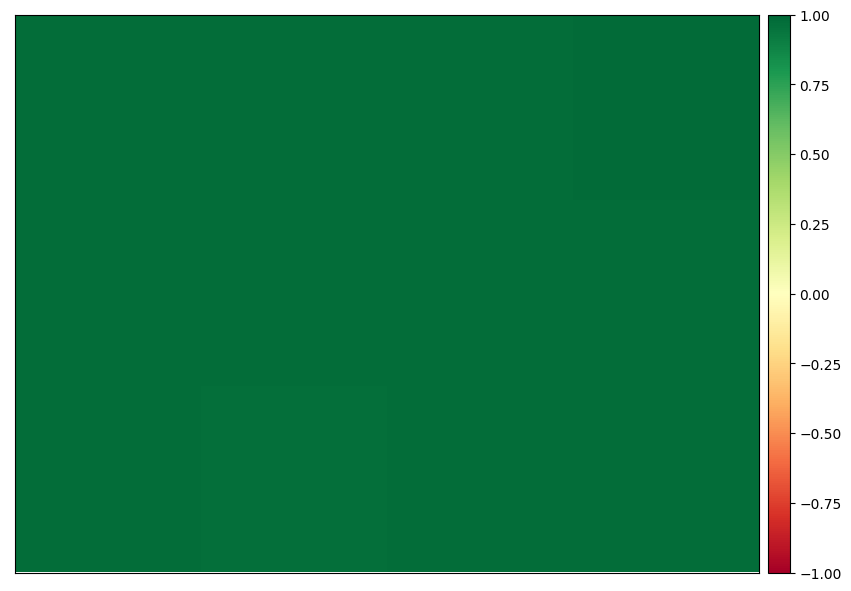

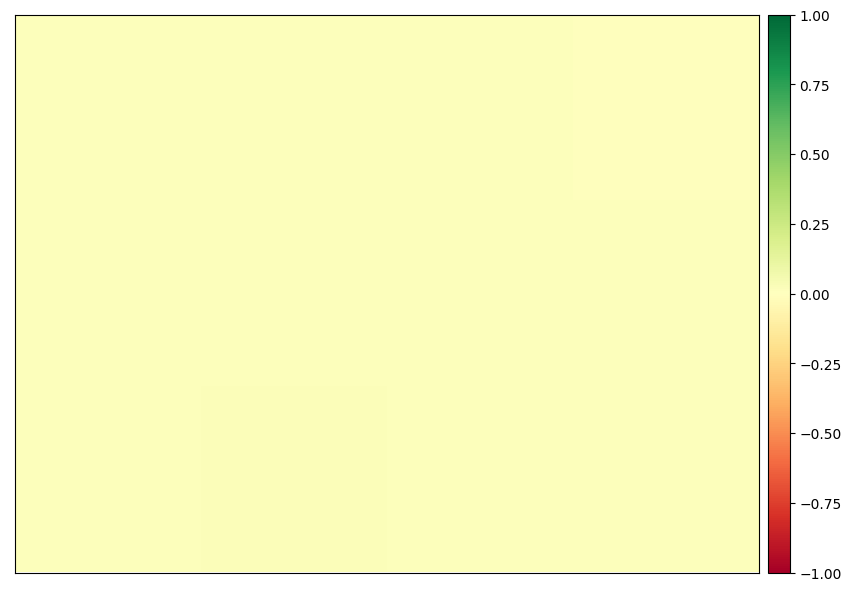

In [9]:
ndvi = es.normalized_diff(stacked_bands[7], stacked_bands[3])

L = 0.5
savi = ((stacked_bands[7] - stacked_bands[3]) / (stacked_bands[7] + stacked_bands[3] + L)) * (1 + L)

vari = (stacked_bands[2] - stacked_bands[3])/ (stacked_bands[2] + stacked_bands[3] - stacked_bands[1])

mndwi = es.normalized_diff(stacked_bands[2], stacked_bands[10])

cmr = np.divide(stacked_bands[10], stacked_bands[11])

indices = [ndvi,savi,vari,mndwi,cmr]

for index in indices:
    ep.plot_bands(index, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

#### Computing indices for all areas

In [21]:
h_max = 1.7
h_min = 0.7
L = 0.5
no_data = -9999

pixel_per_area_list = []
# for each area
for row in bestand.itertuples():
    # get the timed samples for each pixel
    area_samples = np.asarray(row.AllBandsTimed)
    # remove that one useless dimension
    area_samples = area_samples[:,0,:,:,:]
    # reshape (time_samples, x, y, bands) to (time_samples, x*y, bands)
    area_x = area_samples.shape[1]
    area_y = area_samples.shape[2]
    area_samples = area_samples.reshape(area_samples.shape[0],area_samples.shape[1]*area_samples.shape[2],area_samples.shape[3])
    # swap axes to have (x*y, time_samples, bands) to iterate over pixels
    area_samples = area_samples.swapaxes(0,1)
    
    pixel_list = []
    # iterate through the (x*y) pixels
    for pixel in area_samples:

            updated_pixel = pixel

            # compute all the indices
            ndvi = es.normalized_diff(pixel[:,7], pixel[:,3])
            savi = ((pixel[:,7] - pixel[:,3]) / (pixel[:,7] + pixel[:,3] + L)) * (1 + L)
            vari = (pixel[:,2] - pixel[:,3])/ (pixel[:,2] + pixel[:,3] - pixel[:,1])
            mndwi = es.normalized_diff(pixel[:,2], pixel[:,10])
            cmr = np.divide(pixel[:,10], pixel[:,11])

            # get the min and max_pv index through the time_samples
            pv = ((pixel[:,7]-pixel[:,3])/(pixel[:,7]+pixel[:,3]))+ ((pixel[:,7]-pixel[:,1])/(pixel[:,7]+pixel[:,1]))
            pv_max = max(pv)
            pv_min = min(pv)

            # leave this pixel enabled if pv_max_min greater/smaller, else set the mask band to 0
            bare_soil_pixel = 1 if (pv_max>h_max and pv_min<h_min) else 0
            mask_band = [bare_soil_pixel for i in range(pixel.shape[0])]

            indices = [ndvi,savi,vari,mndwi,cmr, pv, mask_band]

            #add the computed indices as bands to each pixel
            for index in indices:
                updated_pixel = np.column_stack((pixel, index))
            #add this pixel with indices to the pixel list
            pixel_list.append(updated_pixel)
    
    # add this set of pixels with indices per area to the list
    # move to np.array with shape (pixel-x, pixel-y, timesamples, bands)
    pixel_list = np.asarray(pixel_list)
    # reshape to (x, y, timesamples, bands)
    pixel_list = pixel_list.reshape(area_x, area_y, pixel_list.shape[1],pixel_list.shape[2])
    pixel_per_area_list.append(pixel_list)

# and set it as new column
bestand["BandsWithIndices"] = np.asarray(pixel_per_area_list)

/home/carlo/GitHub/AISoilIndicator/ai_soil_env/lib/python3.10/site-packages/earthpy/spatial.py:105: RuntimeWarning: invalid value encountered in divide
  n_diff = (b1 - b2) / (b1 + b2)
/tmp/ipykernel_5849/1469938267.py:34: RuntimeWarning: invalid value encountered in divide
  pv = ((pixel[:,7]-pixel[:,3])/(pixel[:,7]+pixel[:,3]))+ ((pixel[:,7]-pixel[:,1])/(pixel[:,7]+pixel[:,1]))
/tmp/ipykernel_5849/1469938267.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bestand["BandsWithIndices"] = np.asarray(pixel_per_area_list)


In [24]:
ex_1 = bestand.at[20,"BandsWithIndices"]

In [25]:
ex_1.shape

(6, 8, 12, 14)

##### Create a Random Forest to see if we can (better) predict SOC

    # 1. Create DF with a large number of satellite samples per area
    # 2. Compute the pv index for each sample
    # 3. Generate pv_max, pv_min for each pixel -> this is on a per-pixel scale whether it is bare soil
    # 4. Mask areas based on whether the pv_ value is greater/smaller than the threshold h_ -> again, for each pixel/image per timestep
    # h_max is used to find fields

    # 5. take intersection of both masks
    #soil_mask = intersection(soil_mask_h_max, soil_mask_h_min)

    # Next steps: apply index computation to each pixel - build the pv index for each pixel, and apply a mask where it doesnt reach the h_max thresholds.
    # then, we have the bare soil pixels and can compute stuff with them (hopefully)

-> need to create masks?
-> finalize with soil reflectances?
-> select the indices they used and repeat prediction